## Importações e leitura

In [31]:
!pip install spacy | { grep -v "already satisfied" || :; }
!python -m spacy download pt_core_news_sm

import numpy as np
import pandas as pd

import json
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download("stopwords")

import pt_core_news_sm

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
df_dataset = pd.read_csv("20052021.csv")

display(df_dataset.shape)
display(df_dataset.head())

(738, 7)

,_id,created_at,tweet_content,keyword,user_location,entities,classification
0,ObjectId(6091f3547ef2d107a44055cc),2021-05-04 12:30:48,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
1,ObjectId(6091f3547ef2d107a44055cd),2021-05-04 12:31:09,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
2,ObjectId(6091f3547ef2d107a44055ce),2021-05-04 12:31:27,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
3,ObjectId(6091f3547ef2d107a44055cf),2021-05-04 12:31:25,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":true,""created_at"":""2021-05-..."
4,ObjectId(6091f3547ef2d107a44055d0),2021-05-04 12:31:20,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."


## Engenharia de atributos

**Como existem ocasiões cujos campos de palavra-chave estão vazios, será feita a remoção desses registros**

In [33]:
# Remoção de amostras onde o campo de palavra-chave é vazio

display(df_dataset.shape)
display(df_dataset["keyword"].unique())

def keywords_to_list(keywords):
    replaced = keywords.strip("[]").replace("'", "")
    if len(replaced) > 0:
        return replaced.split(", ")
    else:
        return []

df_dropempty = df_dataset.copy()
df_dropempty["keyword"] = df_dataset["keyword"].apply(lambda keywords: keywords_to_list(keywords))

df_dataset = df_dataset[df_dropempty["keyword"].str.len() > 0]

display(df_dataset.shape)
display(df_dataset["keyword"].unique())

(738, 7)

array(["['Nubank']", "['Coca-cola']", "['Nike']", "['Xiaomi']",
       "['Coca cola']", "['SHEIN']", '[]', "['Boticário']",
       "['Nike', 'SHEIN']", "['Nike', 'Xiaomi']"], dtype=object)

(722, 7)

array(["['Nubank']", "['Coca-cola']", "['Nike']", "['Xiaomi']",
       "['Coca cola']", "['SHEIN']", "['Boticário']", "['Nike', 'SHEIN']",
       "['Nike', 'Xiaomi']"], dtype=object)

**Será feita, também, a remoção das 72 ocasiões cujos campos de classificação estão vazios**

In [34]:
# Verificação de valores nulos

display(df_dataset.isna().sum())

_id                0
created_at         0
tweet_content      0
keyword            0
user_location      1
entities           0
classification    71
dtype: int64

In [35]:
# Remoção de amostras onde o campo de classifificação é vazio

df_dropna = df_dataset.dropna(subset = ["classification"])

display(df_dataset.shape)
display(df_dropna.shape)

(722, 7)

(651, 7)

In [39]:
# Exibe a quantidade de classificações

def classification_to_list(classifications):
    return classifications.strip("[]").split("},")

df_classification_count = df_dropna.copy()
df_classification_count["classification_count"] = df_dropna["classification"].apply(lambda classification: len(classification_to_list(classification)))

display(Counter(df_classification_count["classification_count"]))

Counter({1: 123, 2: 129, 3: 393, 4: 6})

**Limpeza de atributos irrelevantes**

In [7]:
# Remoção de atributos irrelevantes para a análise

df_removed = df_dropna.drop(["_id", "created_at", "entities"], axis=1)

display(df_removed.shape)
display(df_removed.head(n=2))

(651, 4)

,tweet_content,keyword,user_location,classification
0,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,"[{""classification"":false,""created_at"":""2021-05..."
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,"[{""classification"":false,""created_at"":""2021-05..."


## Análise de keywords

In [8]:
# Valores

display(Counter(df_removed["keyword"]))

Counter({"['Boticário']": 7,
         "['Coca cola']": 57,
         "['Coca-cola']": 14,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1,
         "['Nike']": 177,
         "['Nubank']": 221,
         "['SHEIN']": 150,
         "['Xiaomi']": 23})

Counter({"['Boticário']": 7,
         "['Coca-cola']": 71,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1,
         "['Nike']": 177,
         "['Nubank']": 221,
         "['SHEIN']": 150,
         "['Xiaomi']": 23})

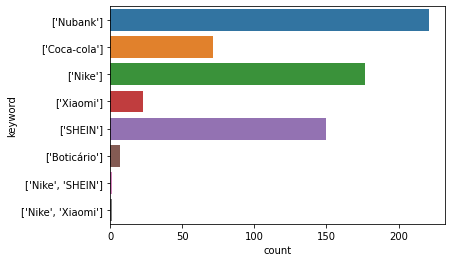

In [9]:
# Normalização de "Coca-Cola"

search = "Coca cola"
replacement = "Coca-cola"

df_normalized = df_removed.copy()
df_normalized["keyword"] = df_removed["keyword"].apply(
    lambda keywords: keywords.lower().replace(search.lower(), replacement) if search.lower() in keywords.lower() else keywords)


# Valores

display(Counter(df_normalized["keyword"]))


# Histograma

sns.countplot(y="keyword", data=df_normalized)

## Tratamento da classificação

Como são 3 classificações para cada registro, ganha a classificação da **maioria** dos registros

Exemplos:

- True, True, False => True
- False, True, False => False

In [10]:
# Criação de um campo de resultado de classificação com a maior ocorrência entre as classificaçações

pd.options.mode.chained_assignment = None

def reducer(input_dict):
  return input_dict["classification"]

def get_classification(input_list):
  return Counter(list(map(reducer, json.loads(input_list)))).most_common()[0][0]

# df_classified = df_normalized.apply(lambda item: get_classification(item[2]), axis=1)

df_normalized["classified"] = df_normalized["classification"].map(lambda classification_list: get_classification(classification_list))

df_classified = df_normalized.drop(["classification"], axis=1)

In [11]:
display(df_classified[df_classified["classified"] == 1].shape)
display(df_classified[df_classified["classified"] == 0].shape)
display(df_classified.shape)

(353, 4)

(298, 4)

(651, 4)

In [12]:
# Transformação numérica da classificação

df_classified["classified"][df_classified["classified"] == True] = 1
df_classified["classified"][df_classified["classified"] == False] = 0

display(df_classified.head())

,tweet_content,keyword,user_location,classified
0,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,0.0
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,1.0
2,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,0.0
3,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil",1.0
4,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil",1.0


## Tokenização e remoção das stopwords

In [13]:
nlp = pt_core_news_sm.load()

In [14]:
def limpar_texto(texto):
    '''
    Função para converter todas as letras para sua forma minúscula, selecionar apenas as letras,
    remover stopwords e lematizar o texto.
    '''
    
    # Removendo as marcas para que elas não apareçam nas wordclouds, pois consomem muito espaço
    marcas = ["nubank", "shein", "nike", "coca", "cola", "xiaomi", "adidas", "boticário",
             "puma"]
    print(len(marcas))
    
    # Stopwords que tiveram que ser adicionadas manualmente
    custom_stops = ["pra", "q", "_", "vai", "vc", "tá", "gente", "tô", "to", "aqui", "tava",
                   "ta", "tá", "hoje", "hj", "-", "eh", "so", "n", "c", "mó", "modalmais",
                   "ouotison", "tbm", "tão", "aí", "nu", "p", "mano", "nois", "pro", "umas",
                   "uns", "então", "x", "ne", "kkkkkkkk", "kkk", "vou", "vcs", "kkkkk", 
                    "nicole", "kkkk", "vivianlana", "gabriel_geno", "ai", "tou", "vir", "ja", 
                    "já", "pq", "amg", "ti", "onde", "meio", "outro", "amigo", "sep_bella",
                   "_gabriel_geno_", "manu", "ir", "tt", "mim", "psg", "sep_bella_", "s",
                   "tudo", "todo", "todos", "rodrigobuenotv", "limite", "aumentar", "querer", 
                    "fazer", "querer", "comprar", "ser", "nathalia", "mt", "en", "d"]
    
    # Palavras identificadas como indiferentes após teste das wordclouds
    palavras_iguais = ["limite", "aumentar", "queria", "faz", "quero", "comprar", "ser"]
    print(len(palavras_iguais))
    
    # Convertendo todas as letras para minúsculas
    minusculas = texto.lower()
    letras = re.findall(r"\b[A-zÀ-úü]+\b", minusculas) 
    
    # Removendo as stopwords
    stops = set(stopwords.words("portuguese")) 
    palavras_sem_stopwords = [w for w in letras if 
                            w not in stops and 
                            w not in marcas and 
                            w not in custom_stops and
                            w not in palavras_iguais]
    palavras_importantes = " ".join(palavras_sem_stopwords)

    # Lemmatizando o texto
    spc_letras = nlp(palavras_importantes)
    lemmas = [token.lemma_ if token.pos_ == "VERB" else str(token) for token in spc_letras]
    texto_limpo = " ".join(lemmas)
    
    return texto_limpo

### Funções de plotagem de alguns gráficos e wordclouds

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off")
    
def plot_tweet_avg_lenght(df):
    return df["tweet_content"].str.len().hist()

def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    
def plot_average_word_lenght(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).hist()

In [16]:
df_clean_text = df_classified.copy()
df_clean_text.head()

,tweet_content,keyword,user_location,classified
0,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,0.0
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,1.0
2,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,0.0
3,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil",1.0
4,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil",1.0


In [17]:
df_clean_text["tweet_content"] = df_classified["tweet_content"].apply(limpar_texto)

9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7
9
7


**Separando os datasets em positivo e negativo para formar as wordclouds**

In [18]:
df_positive = df_clean_text[df_clean_text["classified"] == 1.0]
df_positive.head()

,tweet_content,keyword,user_location,classified
1,viciar bateria celular,['Coca-cola'],Balneário Camboriú,1.0
3,pedi serasi,['Nubank'],"Rio de Janeiro, Brasil",1.0
4,kayofeer acontecer mãe quase ano nada ainda,['Nubank'],"Macaé, Brasil",1.0
5,escolher aumentar reais uau revolucionário kkk...,['Nubank'],"Ribeirão Preto, Brasil",1.0
6,achar preju tempos algo inesperado ahhh inocente,['Nubank'],"São Paulo, Brasil",1.0


In [19]:
df_negative = df_clean_text[df_clean_text["classified"] == 0.0]
df_negative.head()

,tweet_content,keyword,user_location,classified
0,mds nunca liberar,['Nubank'],Goiânia,0.0
2,toda vez ver lá conferir saldo certo juro trau...,['Nubank'],None,0.0
7,rodrigolps _ caso observar aumentar juros dívida,['Nubank'],🏳️‍🌈,0.0
8,msswx processo n eles,['Nubank'],Macaé,0.0
12,gastar cueca calvin klein,['Nike'],Hell not Helsinki,0.0


FileNotFoundError: ignored

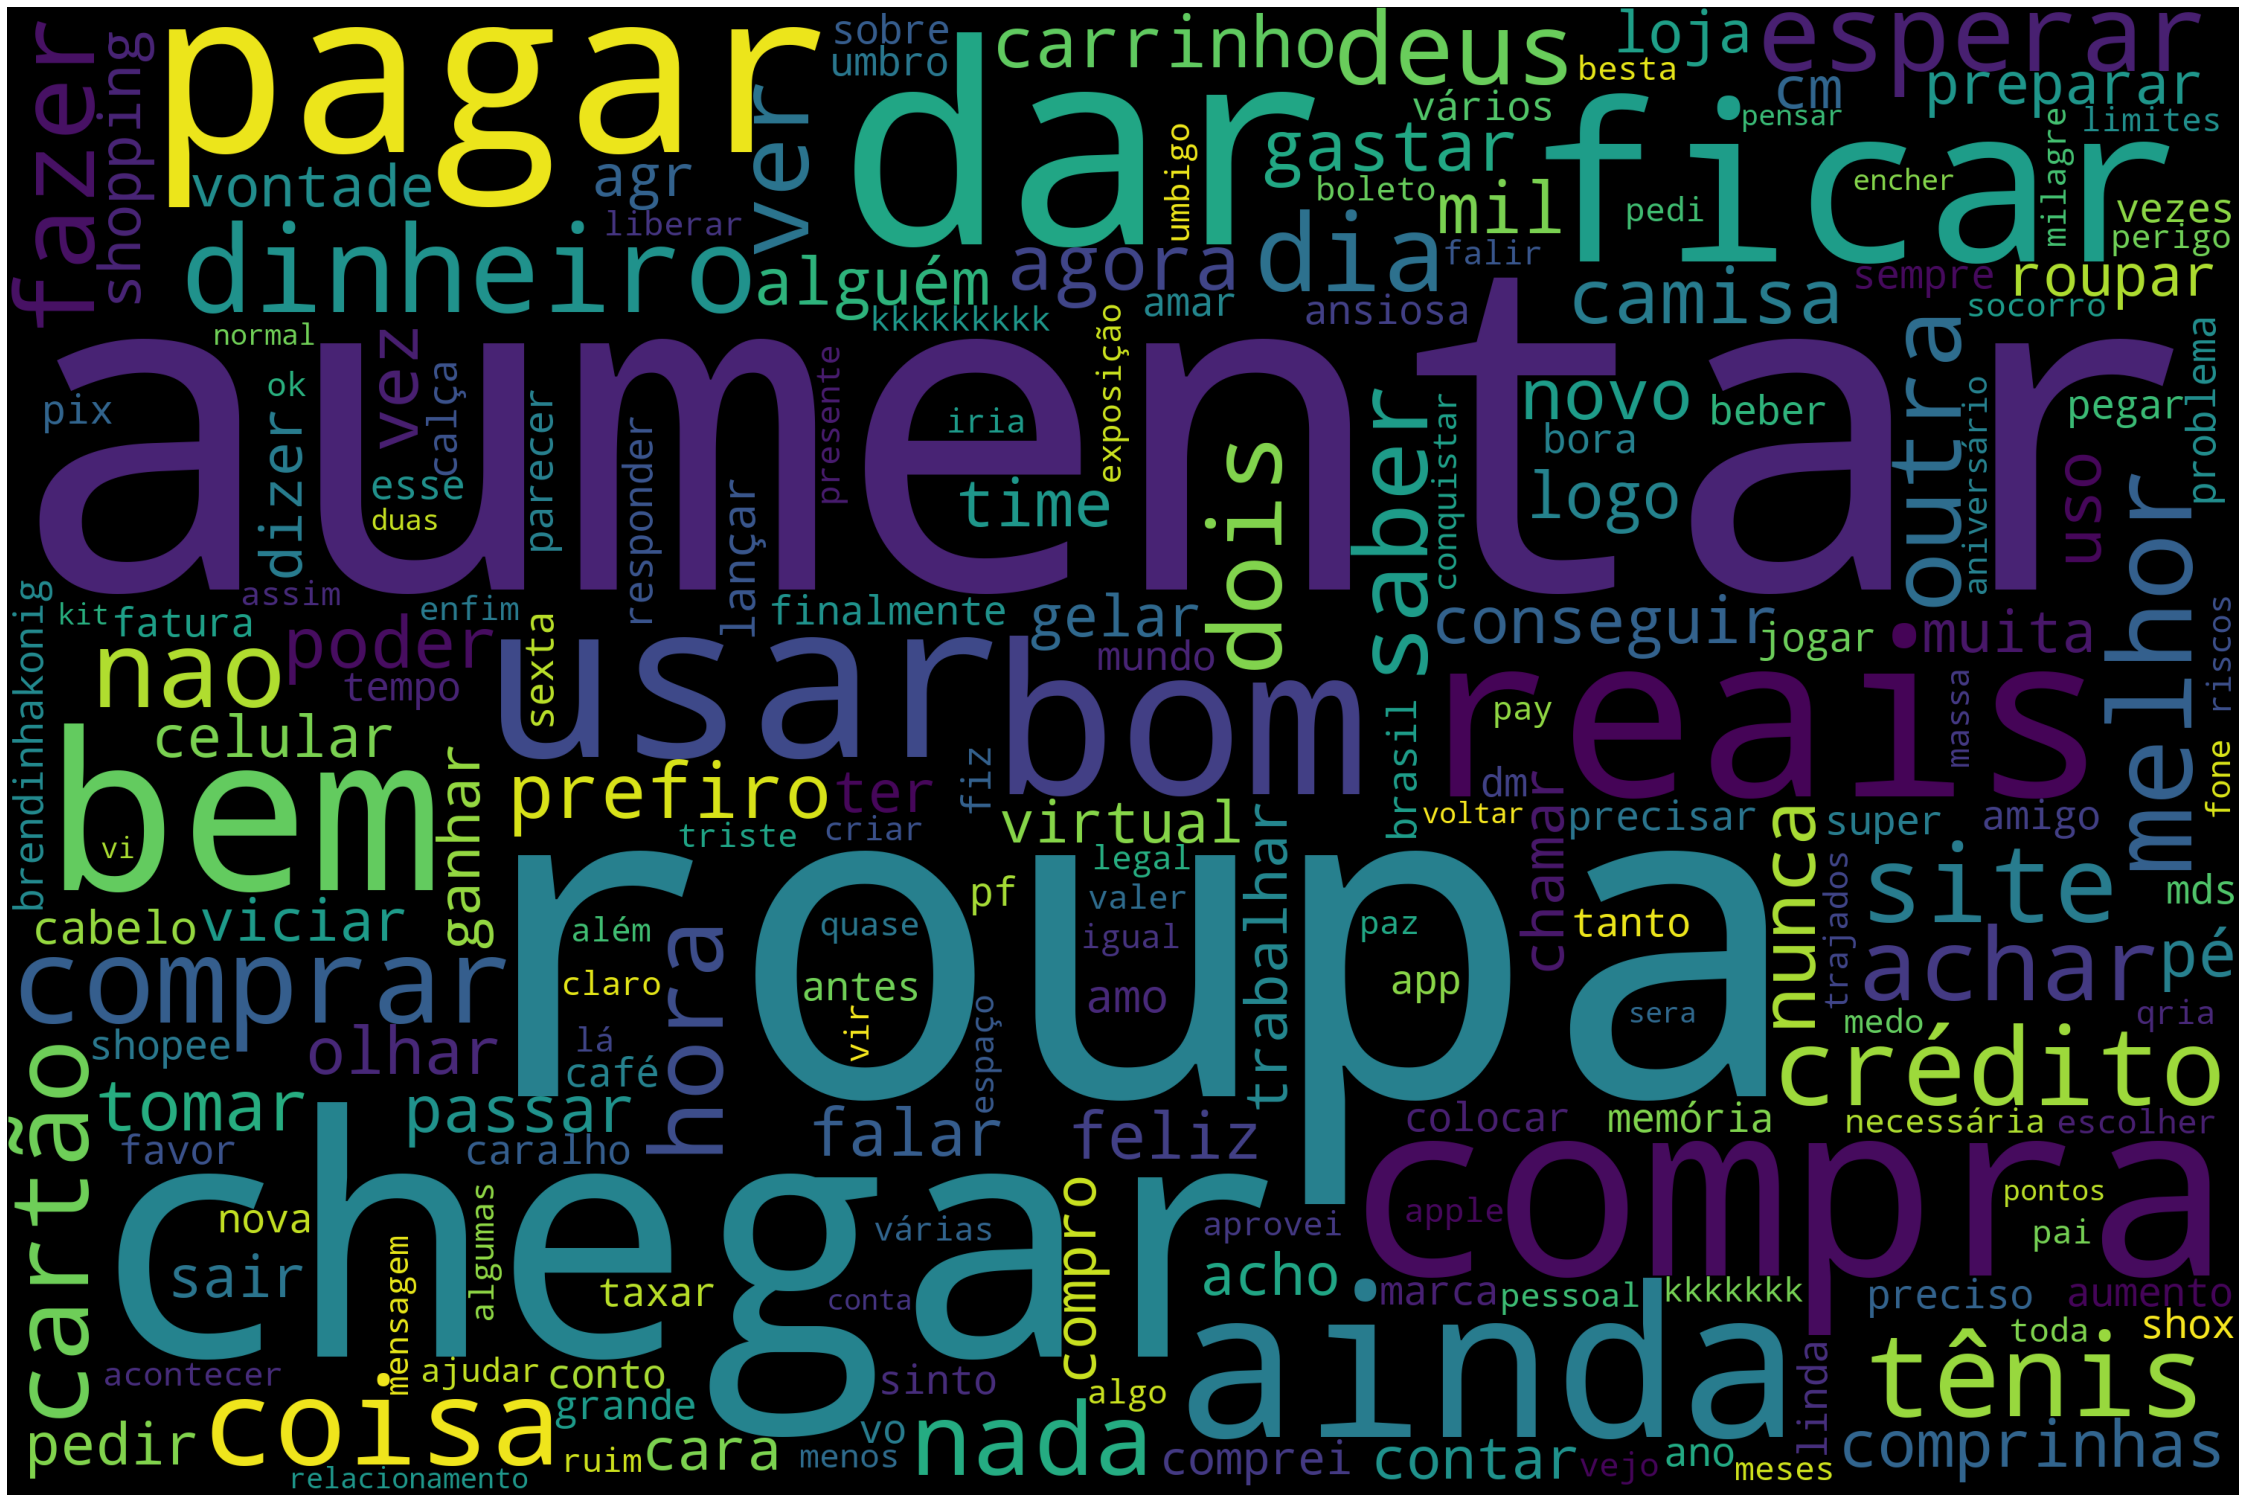

In [20]:
wordcloud_pos = WordCloud(width = 3000, height = 2000, random_state=1,
                      collocations=False).generate(" ".join(df_positive["tweet_content"]))

plot_cloud(wordcloud_pos)
wordcloud_pos.to_file("img/pos_wordcloud.png")

In [ ]:
wordcloud_neg = WordCloud(width = 3000, height = 2000, random_state=1,
                      collocations=False).generate(" ".join(df_negative["tweet_content"]))

plot_cloud(wordcloud_neg)
wordcloud_neg.to_file("img/neg_wordcloud.png")

**Salvando os dataframes em arquivos csv para serem utilizados depois**

In [ ]:
df_clean_text.to_csv("files/clean_text.csv")
df_positive.to_csv("files/positive.csv")
df_negative.to_csv("files/negative.csv")

**Plotando sentimentos por palavra-chave**

In [ ]:
# Dataframe especialmente para o plot

order = ["Positiva", "Negativa"]

df_countplot = df_clean_text.copy()
df_countplot = df_countplot.rename({"classified": "Classificação"}, axis=1)
df_countplot["Classificação"][df_countplot["Classificação"] == 1.0] = order[0]
df_countplot["Classificação"][df_countplot["Classificação"] == 0.0] = order[1]


# Plot

colors = ["#8FD14F", "#BC4C4B"]
sns.set_palette(sns.color_palette(colors))
plot_output = sns.countplot(y="keyword",
                            data=df_countplot,
                            hue="Classificação",
                            hue_order=order)

plot_output.legend(loc="lower right")

plot_output.set_title("Sentimentos por Palavra-chave", fontsize=16, fontweight="bold")
plot_output.set_xlabel("Quantidade de tweets", fontsize=14)
plot_output.set_ylabel("Palavras-chave", fontsize=14)

plot_output.spines["top"].set_visible(False)
plot_output.spines["right"].set_visible(False)

for rect in plot_output.patches:
    plot_output.text(rect.get_width(),
                     rect.get_y(),
                     str(rect.get_width())[:-2],
                     horizontalalignment="left",
                     verticalalignment="top",
                     fontsize=11)

plot_output.figure.savefig("img/keyword_analysis_labeled.png", bbox_inches="tight")